In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

from pykrige.ok import OrdinaryKriging

import warnings
warnings.simplefilter(action='ignore')

In [13]:
"""
Удаление выбросов с использованием межквартильного размаха (IQR)
"""
def get_filter_df(df, col):
    # Определяем Q1 и Q3 квартили
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    
    # Вычисляем IQR
    IQR = Q3 - Q1
    
    # Определяем границы для определения выбросов
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Фильтруем выбросы
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

In [14]:
"""
Создание матрицы расстояний
"""
def matrix_distance(points):
    l = len(points)
    matrix = np.zeros((l, l))
    
    for i in range(l):
        for j in range(i, l):
            distance = np.linalg.norm(points[i] - points[j])
            matrix[i, j] = distance
    
    return matrix+matrix.T

# Пример
B = np.array([[1, 2, 3], [3, 4, 5], [1, 5, 7], [1, 2, 4]])
matrix_distance(B)

array([[0.        , 3.46410162, 5.        , 1.        ],
       [3.46410162, 0.        , 3.        , 3.        ],
       [5.        , 3.        , 0.        , 4.24264069],
       [1.        , 3.        , 4.24264069, 0.        ]])

In [15]:
"""
Создание матрицы расстояний
"""
def matrix_distance_for_kriging(points):
    l = len(points)
    matrix = np.zeros((l+1, l+1))
    
    for i in range(l):
        for j in range(i, l):
            distance = np.linalg.norm(points[i] - points[j])
            matrix[i, j] = distance

    matrix[-1, :-1] += 1
    
    return matrix+matrix.T

# Пример
B = np.array([[1, 2, 3], [3, 4, 5], [1, 5, 7], [1, 2, 4]])
matrix_distance_for_kriging(B)

array([[0.        , 3.46410162, 5.        , 1.        , 1.        ],
       [3.46410162, 0.        , 3.        , 3.        , 1.        ],
       [5.        , 3.        , 0.        , 4.24264069, 1.        ],
       [1.        , 3.        , 4.24264069, 0.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 0.        ]])

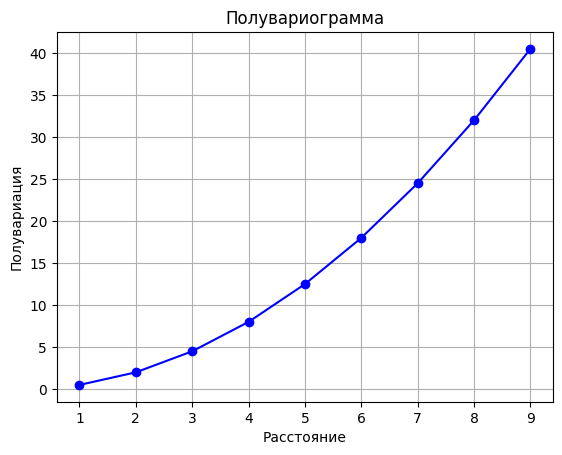

In [16]:
def calculate_semivariance(data, lag, max_distance):
    """
    Функция для расчета полувариограммы.
    :param data: массив данных в формате numpy
    :param lag: шаг расстояния для расчета полувариограммы
    :param max_distance: максимальное расстояние для расчета
    :return: списки расстояний и соответствующих полувариансов
    """
    distances = np.arange(lag, max_distance, lag)
    semivariances = []

    for distance in distances:
        pairs = []
        for i in range(len(data)):
            for j in range(i+1, len(data)):
                if abs(i - j) * lag == distance:
                    pairs.append((data[i], data[j]))
        
        if pairs:
            semivariances.append(np.mean([(pair[0] - pair[1])**2 / 2 for pair in pairs]))
        else:
            semivariances.append(0)
    
    return distances, semivariances

# Пример данных
data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

lag = 1  # Шаг расстояния
max_distance = 10 # Максимальное расстояние
distances, semivariances = calculate_semivariance(data, lag, max_distance)

# Визуализация полувариограммы
plt.plot(distances, semivariances, 'bo-')
plt.title('Полувариограмма')
plt.xlabel('Расстояние')
plt.ylabel('Полувариация')
plt.grid()
plt.show()


# Обратока скважины

## Определение тренда и остатка

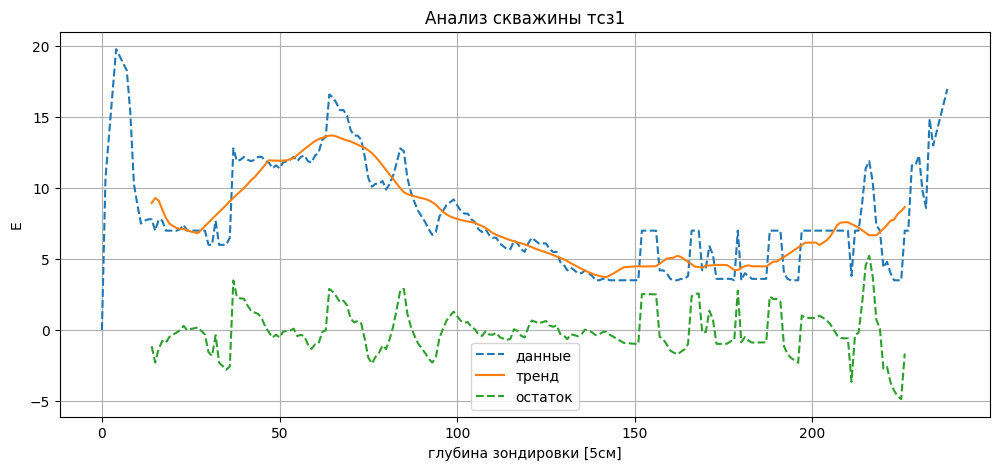

In [17]:
df = pd.read_excel(f"data/тсз1.xlsx")
df = df.loc[:, ["E", "soil_kind"]]
df_filter = get_filter_df(df, "E")
# Вычисление скользящего среднего для определения тренда
window_size = 20  # Размер окна для скользящего среднего
df_filter['Trend'] = df_filter['E'].rolling(window=window_size, center=True).mean()
# Вычисление случайной составляющей как разность исходных данных и тренда
df_filter['Random'] = df_filter['E'] - df_filter['Trend']

plt.figure(figsize=(12, 5))
plt.plot(df_filter.index, df_filter["E"], '--', label="данные")
plt.plot(df_filter.index, df_filter["Trend"], '-', label="тренд")
plt.plot(df_filter.index, df_filter["Random"], '--', label="остаток")
plt.title('Анализ скважины тсз1')
plt.xlabel('глубина зондировки [5см]')
plt.ylabel('E')
plt.grid()
plt.legend()
plt.show()

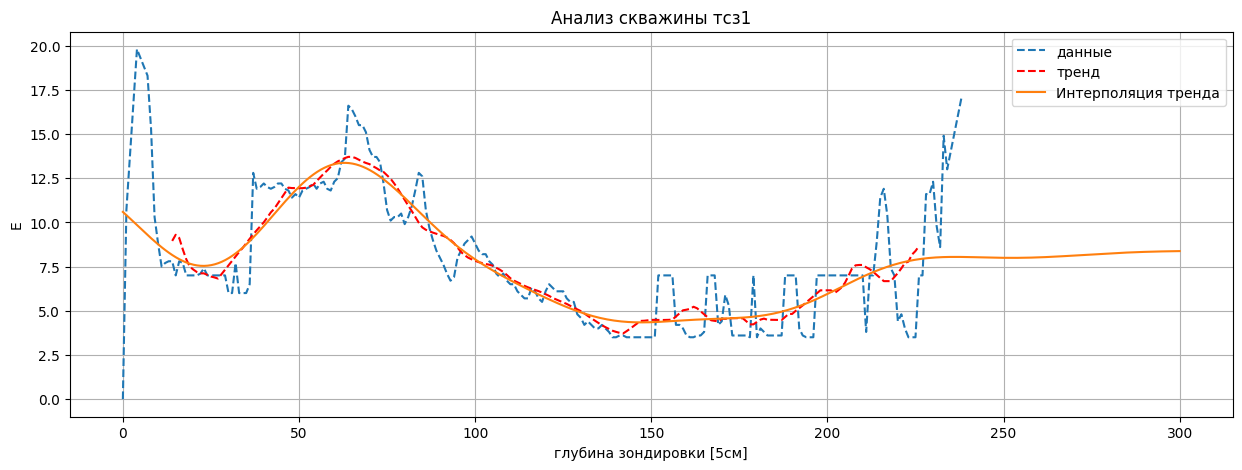

In [18]:
df_now = df_filter.dropna(subset=["Trend"])
x = df_now.index.to_numpy()
y = df_now["Trend"].to_numpy()

# Создание объекта OrdinaryKriging
OK = OrdinaryKriging(x, np.zeros_like(x), y, variogram_model='gaussian')

# Новые точки для интерполяции
x_new = np.linspace(0, 300, 300)

# Выполнение интерполяции
y_new, ss = OK.execute('grid', x_new, np.zeros_like(x_new))

# Построение графика
plt.figure(figsize=(15, 5))
plt.title('Анализ скважины тсз1')
plt.xlabel('глубина зондировки [5см]')
plt.ylabel('E')
#plt.plot(x, y, 'o', label='Исходные данные')

plt.plot(df_filter.index, df_filter["E"], '--', label="данные")
plt.plot(df_filter.index, df_filter["Trend"], '--r', label="тренд")

plt.plot(x_new, y_new[0,:], '-', label='Интерполяция тренда')
plt.legend()
plt.grid()
plt.show()

trend_krig = [x_new, y_new]

## Проверка стационарности остатка

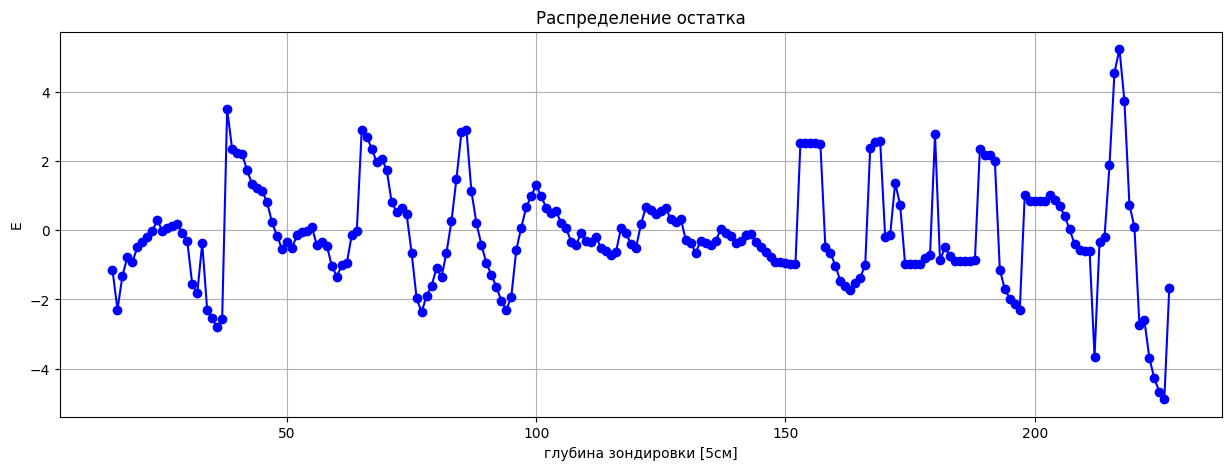

'\nСтохастический процесс стационарен, так как распределение не зависит от глубины зондировки\n'

In [19]:
# Проверка стационарности
plt.figure(figsize=(15, 5))
plt.plot(df_filter.index, df_filter["Random"].shift(), 'bo-')
plt.title('Распределение остатка')
plt.xlabel('глубина зондировки [5см]')
plt.ylabel('E')
plt.grid()
plt.show()
"""
Стохастический процесс стационарен, так как распределение не зависит от глубины зондировки
"""

## Полувариограммы

### Работа с остатком

Оптимальные параметры: наггет = 0.15758314298288956 , порог = 2.1242504693376456 , фактический ранг = 4.01323443393216


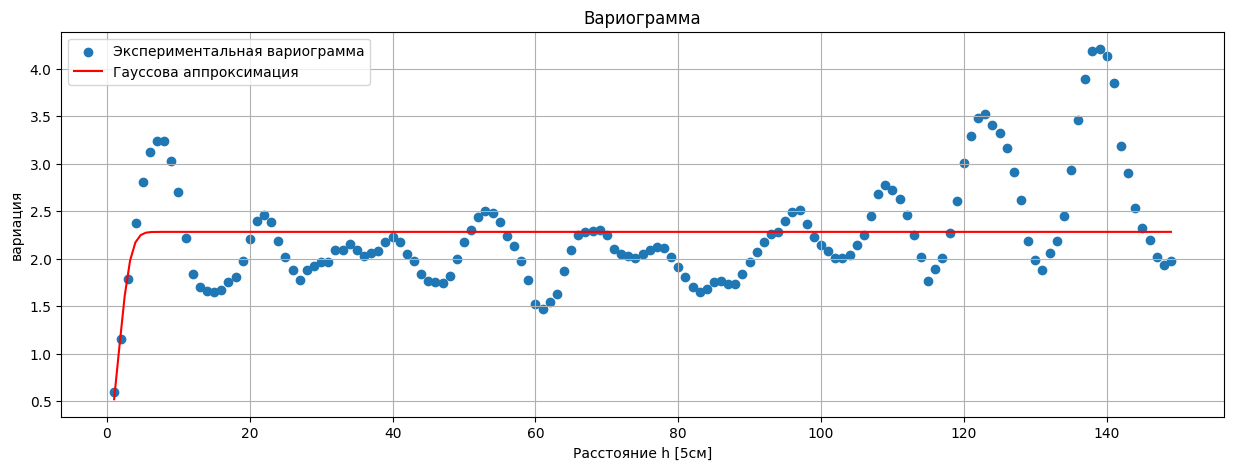

In [20]:
"""
полувар по остатку
"""
data = df_filter['Random'].dropna().to_numpy()

lag = 1  # Шаг расстояния
max_distance = 150  # Максимальное расстояние
distances, semivariances = calculate_semivariance(data, lag, max_distance)



x_data = distances.copy() #np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
y_data = semivariances.copy() #np.array([1.2, 2.8, 3.6, 4.5, 5.1, 4.8, 3.9, 2.5, 1.7, 1.1])
plt.figure(figsize=(15, 5))

def gaussian(h, nugget, sill, rang):
    return nugget + sill * (1 - np.exp(-3*(h / rang)**2))


# Аппроксимация данных
popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 5, 1])

# Оптимальные параметры
a_opt, b_opt, c_opt = popt
print("Оптимальные параметры: наггет =", a_opt, ", порог =", b_opt, ", фактический ранг =", c_opt)

# Построение исходных данных и аппроксимированной функции
x_fit = np.linspace(min(x_data), max(x_data), 200)
y_fit = gaussian(x_fit, *popt)

plt.scatter(x_data, y_data, label='Экспериментальная вариограмма')
plt.plot(x_fit, y_fit, label='Гауссова аппроксимация', color='red')
plt.title('Вариограмма')
plt.xlabel('Расстояние h [5см]')
plt.ylabel('вариация')
plt.legend()
plt.grid()
plt.show()

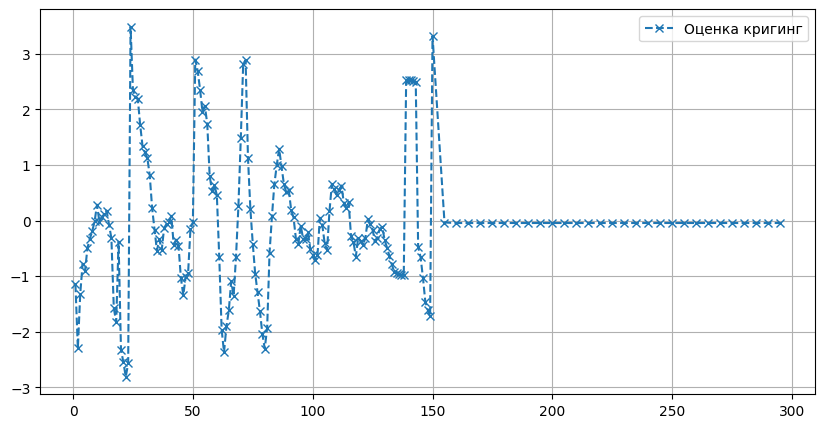

In [21]:
x_data = distances.copy() #np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
y_data = np.array(semivariances.copy()) #np.array([1.2, 2.8, 3.6, 4.5, 5.1, 4.8, 3.9, 2.5, 1.7, 1.1])
result_data = data[:149].copy()
step_iter = 5

for xi in range(150, 300, step_iter):
    matrix_d = pd.DataFrame(matrix_distance(x_data)).applymap(lambda x: 
                                                              gaussian(x, *popt)
                                                              #y_data[int(x)-1] if x != 0 else 1
                                                             ).to_numpy()
    np.fill_diagonal(matrix_d, 1)
    matrix_d = np.concatenate((matrix_d, np.array([[1]*matrix_d.shape[0]])), axis=0)
    matrix_d = np.concatenate((matrix_d, np.array([[1]*matrix_d.shape[1]+ [0]]).T), axis=1)
    
    vector_gamma = np.append(gaussian(xi - x_data, *popt), 1)
    #vector_gamma = np.append(y_data[xi - x_data - 1], 1)
    

    # Решение системы уравнений
    solution = np.linalg.solve(matrix_d, vector_gamma)
    #result = np.dot(y_data, solution[:-1])
    result = np.dot(np.append(result_data, 1), solution)
    
    x_data = np.append(x_data, xi) 
    result_data = np.append(result_data, result)

plt.figure(figsize=(10, 5))
plt.grid()
plt.plot(x_data, result_data, "--x", label="Оценка кригинг")
#plt.plot(x_data[:data_plot.shape[0]], data_plot, "o", label="Реальные данные")
plt.legend()
plt.show()

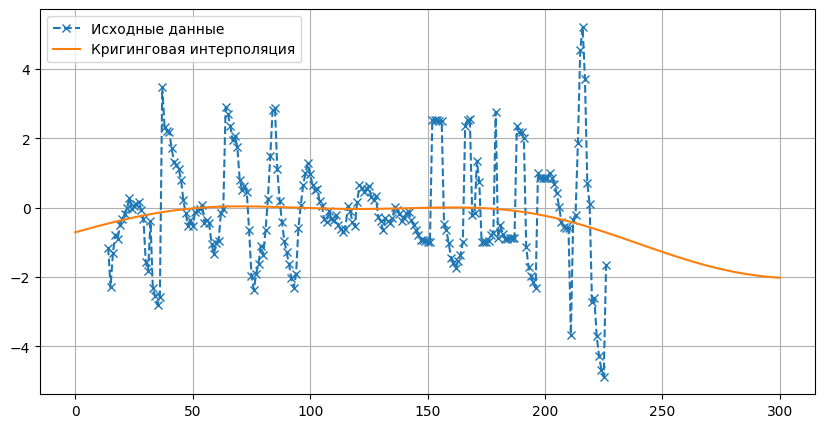

In [22]:
df_now = df_filter.dropna(subset=["Random"])
x = df_now.index.to_numpy()
y = df_now["Random"].to_numpy()

# Создание объекта OrdinaryKriging
OK = OrdinaryKriging(x, np.zeros_like(x), y, variogram_model='gaussian')

# Новые точки для интерполяции
x_new = np.linspace(0, 300, 300)

# Выполнение интерполяции
y_new, ss = OK.execute('grid', x_new, np.zeros_like(x_new))

# Построение графика
plt.figure(figsize=(10, 5))
plt.grid()
plt.plot(x, y, '--x', label='Исходные данные')
plt.plot(x_new, y_new[0,:], '-', label='Кригинговая интерполяция')
plt.legend()
plt.show()

random_krig = [x_new, y_new]

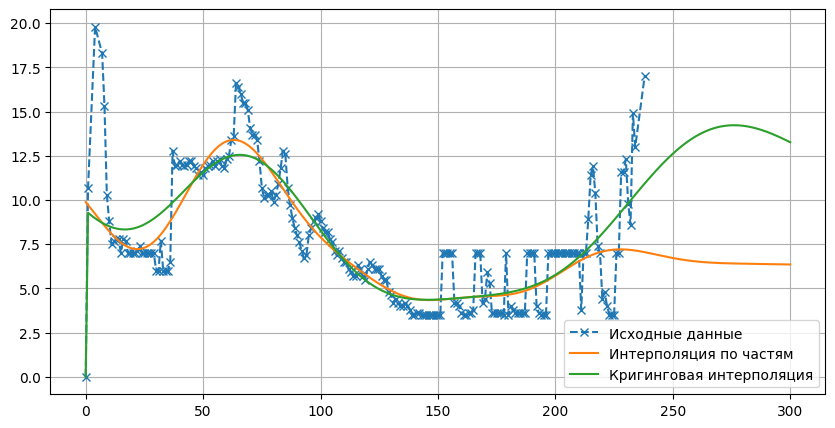

In [23]:
x = df_filter.index.to_numpy()
y = df_filter["E"].to_numpy()


OK = OrdinaryKriging(x, np.zeros_like(x), y, variogram_model='gaussian')

x_new = np.linspace(0, 300, 300)

y_new, ss = OK.execute('grid', x_new, np.zeros_like(x_new))

# Построение графика
plt.figure(figsize=(10, 5))
plt.grid()
plt.plot(df_filter.index, df_filter["E"], '--x', label='Исходные данные')
plt.plot(random_krig[0], random_krig[1][0,:] + trend_krig[1][0,:], '-', label='Интерполяция по частям')
plt.plot(x_new, y_new[0,:], '-', label='Кригинговая интерполяция')
plt.legend()
plt.show()

### Все данные

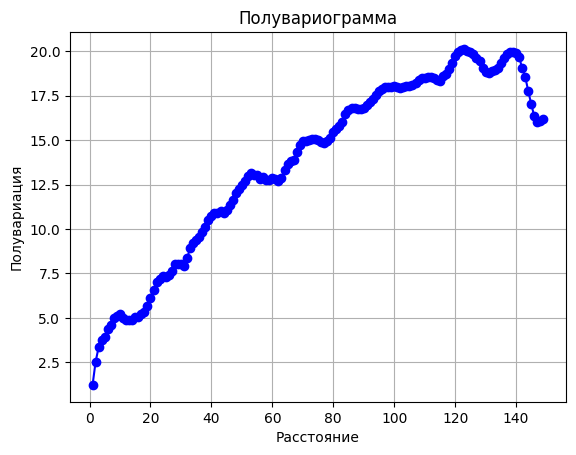

In [24]:
"""
полувар по всем данным
"""
data = df_filter['E'].dropna().to_numpy()

lag = 1  # Шаг расстояния
max_distance = 150  # Максимальное расстояние
distances, semivariances = calculate_semivariance(data, lag, max_distance)

# Визуализация полувариограммы
plt.plot(distances, semivariances, 'bo-')
plt.title('Полувариограмма')
plt.xlabel('Расстояние')
plt.ylabel('Полувариация')
plt.grid()
plt.show()

Из графика экспер. вариограммы следует, что  
Ранг = 120  
Наггет = 0

## Построение теоретической вариограммы

Оптимальные параметры: наггет = 4.553793160796198 , порог = 14.275662850017458 , фактический ранг = 104.58987067334594


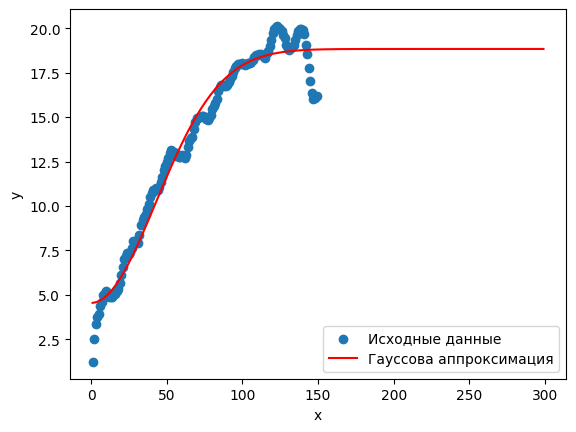

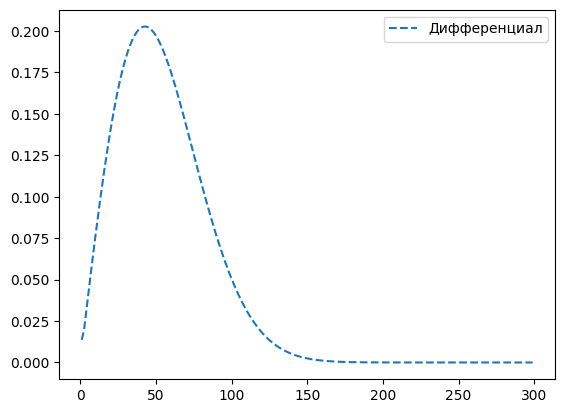

In [25]:
# Пример данных
x_data = distances.copy() #np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
y_data = semivariances.copy() #np.array([1.2, 2.8, 3.6, 4.5, 5.1, 4.8, 3.9, 2.5, 1.7, 1.1])


def gaussian(h, nugget, sill, rang):
    return nugget + sill * (1 - np.exp(-3*(h / rang)**2))


# Аппроксимация данных
popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 5, 1])

# Оптимальные параметры
a_opt, b_opt, c_opt = popt
print("Оптимальные параметры: наггет =", a_opt, ", порог =", b_opt, ", фактический ранг =", c_opt)

# Построение исходных данных и аппроксимированной функции
x_fit = np.linspace(min(x_data), max(x_data) + 150, 200)
y_fit = gaussian(x_fit, *popt)

plt.scatter(x_data, y_data, label='Исходные данные')
plt.plot(x_fit, y_fit, label='Гауссова аппроксимация', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


dy_dx = np.gradient(y_fit, x_fit)
plt.plot(x_fit, dy_dx, label='Дифференциал', linestyle='--')
plt.legend()
plt.show()

-31.92151718860536 34.96140475771571 0.010330517183520953 0.005501973765290866 -0.013695100280429688


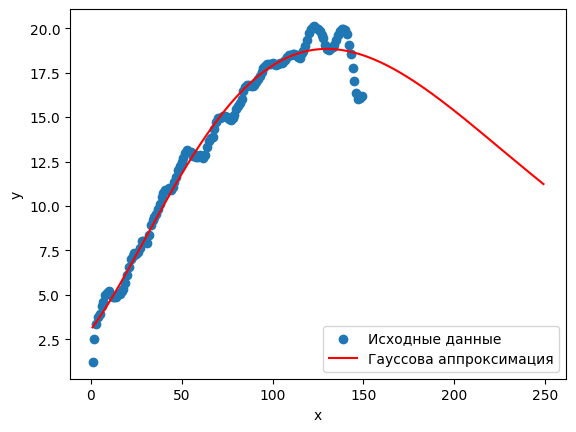

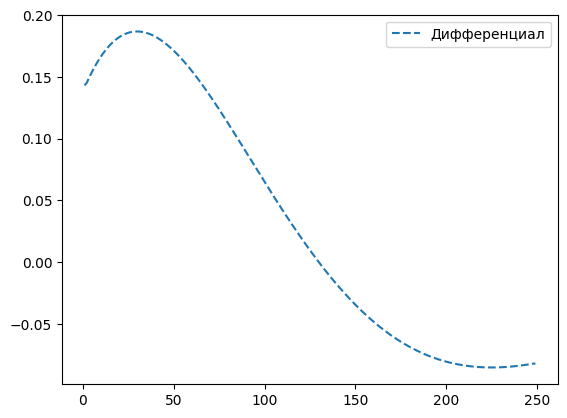

In [34]:
# Пример данных
x_data = distances.copy() #np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
y_data = semivariances.copy() #np.array([1.2, 2.8, 3.6, 4.5, 5.1, 4.8, 3.9, 2.5, 1.7, 1.1])


def gaussian(h, d1, df, a1, af, w):
    return d1*np.exp(-a1*h)*np.cos(w*h) + df*np.exp(-af*h)


# Аппроксимация данных
popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[3, 1, 0.1, 0.4, 0.25])

# Оптимальные параметры
d1, df, a1, af, w  = popt
print(d1, df, a1, af, w)

# Построение исходных данных и аппроксимированной функции
x_fit = np.linspace(min(x_data), max(x_data) + 100, 200)
y_fit = gaussian(x_fit, *popt)

plt.scatter(x_data, y_data, label='Исходные данные')
plt.plot(x_fit, y_fit, label='Гауссова аппроксимация', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


dy_dx = np.gradient(y_fit, x_fit)
plt.plot(x_fit, dy_dx, label='Дифференциал', linestyle='--')
plt.legend()
plt.show()

# Кригинг

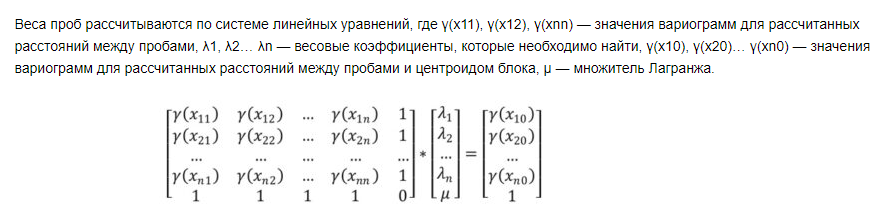

In [26]:
# Коэффициенты системы уравнений
# 2x + 3y = 8
# 3x + 4y = 11
A = np.array([[2, 3], [3, 4]])
B = np.array([8, 11])

# Решение системы уравнений
solution = np.linalg.solve(A, B)

# Вывод решения
print(f"x = {solution[0]}, y = {solution[1]}")

x = 1.0, y = 2.0


(149,) (150,)
(150,) (151,)
(151,) (152,)
(152,) (153,)
(153,) (154,)
(154,) (155,)
(155,) (156,)
(156,) (157,)
(157,) (158,)
(158,) (159,)
(159,) (160,)
(160,) (161,)
(161,) (162,)
(162,) (163,)
(163,) (164,)
(164,) (165,)
(165,) (166,)
(166,) (167,)
(167,) (168,)
(168,) (169,)
(169,) (170,)
(170,) (171,)
(171,) (172,)
(172,) (173,)
(173,) (174,)
(174,) (175,)
(175,) (176,)
(176,) (177,)
(177,) (178,)
(178,) (179,)


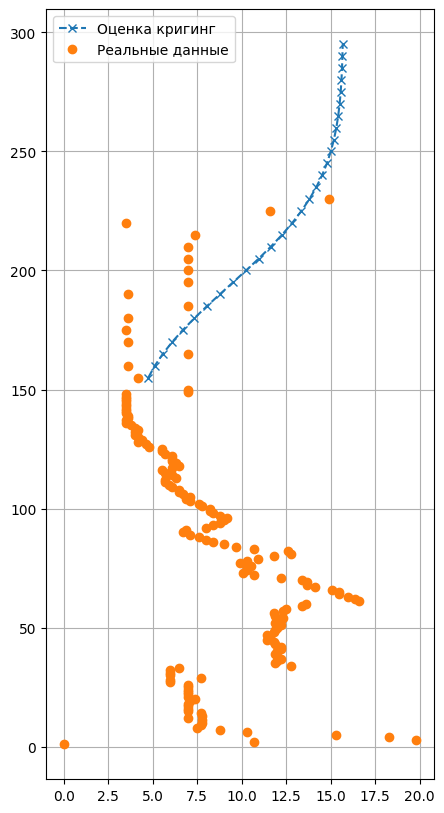

In [27]:
x_data = distances.copy() #np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
y_data = np.array(semivariances.copy()) #np.array([1.2, 2.8, 3.6, 4.5, 5.1, 4.8, 3.9, 2.5, 1.7, 1.1])
result_data = data[:149].copy()
step_iter = 5

for xi in range(150, 300, step_iter):
    matrix_d = pd.DataFrame(matrix_distance(x_data)).applymap(lambda x: 
                                                              gaussian(x, *popt)
                                                              #y_data[int(x)-1] if x != 0 else 1
                                                             ).to_numpy()
    np.fill_diagonal(matrix_d, 1)
    matrix_d = np.concatenate((matrix_d, np.array([[1]*matrix_d.shape[0]])), axis=0)
    matrix_d = np.concatenate((matrix_d, np.array([[1]*matrix_d.shape[1]+ [0]]).T), axis=1)
    
    vector_gamma = np.append(gaussian(xi - x_data, *popt), 1)
    #vector_gamma = np.append(y_data[xi - x_data - 1], 1)
    

    # Решение системы уравнений
    solution = np.linalg.solve(matrix_d, vector_gamma)
    #result = np.dot(y_data, solution[:-1])
    print(result_data.shape, solution.shape)
    result = np.dot(np.append(result_data, 1), solution)
    
    x_data = np.append(x_data, xi) 
    result_data = np.append(result_data, result)

data_plot = np.append(data[:149], data[149::step_iter])

plt.figure(figsize=(5, 10))
plt.grid()
plt.plot(result_data[150:], x_data[150:], "--x", label="Оценка кригинг")
plt.plot(data_plot, x_data[:data_plot.shape[0]], "o", label="Реальные данные")
plt.legend()
plt.show()

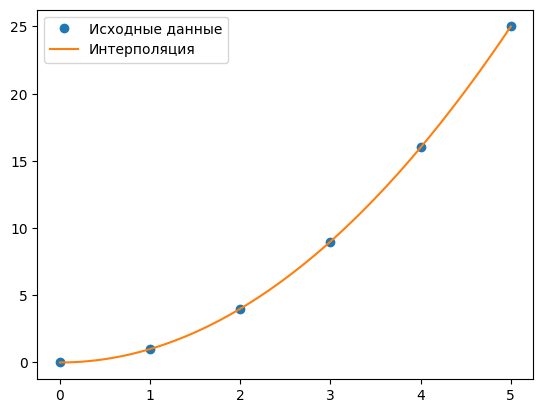

In [28]:
# Пример данных
x = np.array([0, 1, 2, 3, 4, 5])
y = np.array([0, 1, 4, 9, 16, 25])

# Создание интерполяционной функции
f = interp1d(x, y, kind='cubic')

# Новые точки для интерполяции
x_new = np.linspace(0, 5, 100)
y_new = f(x_new)

# Построение графика
plt.plot(x, y, 'o', label='Исходные данные')
plt.plot(x_new, y_new, '-', label='Интерполяция')
plt.legend()
plt.show()

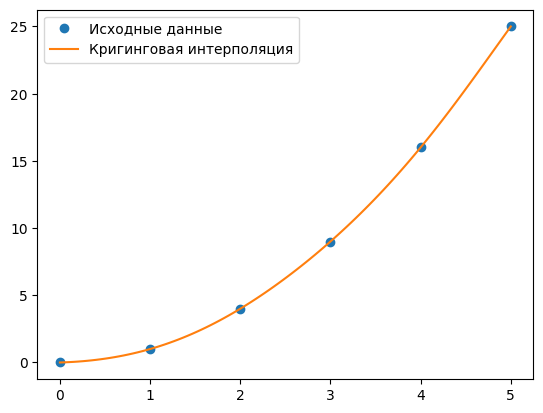

In [29]:
from pykrige.ok import OrdinaryKriging

# Пример данных
x = np.array([0, 1, 2, 3, 4, 5])
y = np.array([0, 1, 4, 9, 16, 25])

# Создание объекта OrdinaryKriging
OK = OrdinaryKriging(x, np.zeros_like(x), y, variogram_model='gaussian')

# Новые точки для интерполяции
x_new = np.linspace(0, 5, 100)

# Выполнение интерполяции
y_new, ss = OK.execute('grid', x_new, np.zeros_like(x_new))

# Построение графика
plt.plot(x, y, 'o', label='Исходные данные')
plt.plot(x_new, y_new[0,:], '-', label='Кригинговая интерполяция')
plt.legend()
plt.show()